<a href="https://colab.research.google.com/github/saatvik1879/mltask/blob/main/MLtask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## reading data and visualisation

In [84]:
df = pd.get_dummies(pd.read_csv("/content/lungcapacity.csv"))
#had to remove row 202 as it had age = 999
df = df.drop([202])
#dropping rows containing nan values
df = df.dropna()
#pandas to numpy
X = df.to_numpy().astype('float32')[:,1:]
y = df.to_numpy().astype('float32')[:,0]
df

,LungCap(cc),Age( years),Height(inches),No of children,Weight (kg),Smoke_9,Smoke_no,Smoke_yes,Gender_female,Gender_male,Caesarean_999,Caesarean_no,Caesarean_yes
0,6.475,6.0,62.1,3,85.70,False,False,False,False,True,False,True,False
1,10.125,18.0,74.7,0,98.75,False,False,True,True,False,False,True,False
2,9.550,16.0,69.7,0,11.01,False,True,False,True,False,False,False,True
3,11.125,14.0,71.0,1,29.78,False,True,False,False,True,False,True,False
4,4.800,5.0,56.9,4,72.84,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,9.325,14.0,65.5,0,65.50,False,True,False,False,True,False,True,False
741,9.925,16.0,68.3,3,68.30,False,True,False,True,False,False,True,False
742,8.725,19.0,68.4,3,68.40,False,True,False,True,False,False,True,False
743,7.075,11.0,66.7,4,66.70,False,True,False,False,True,False,False,True


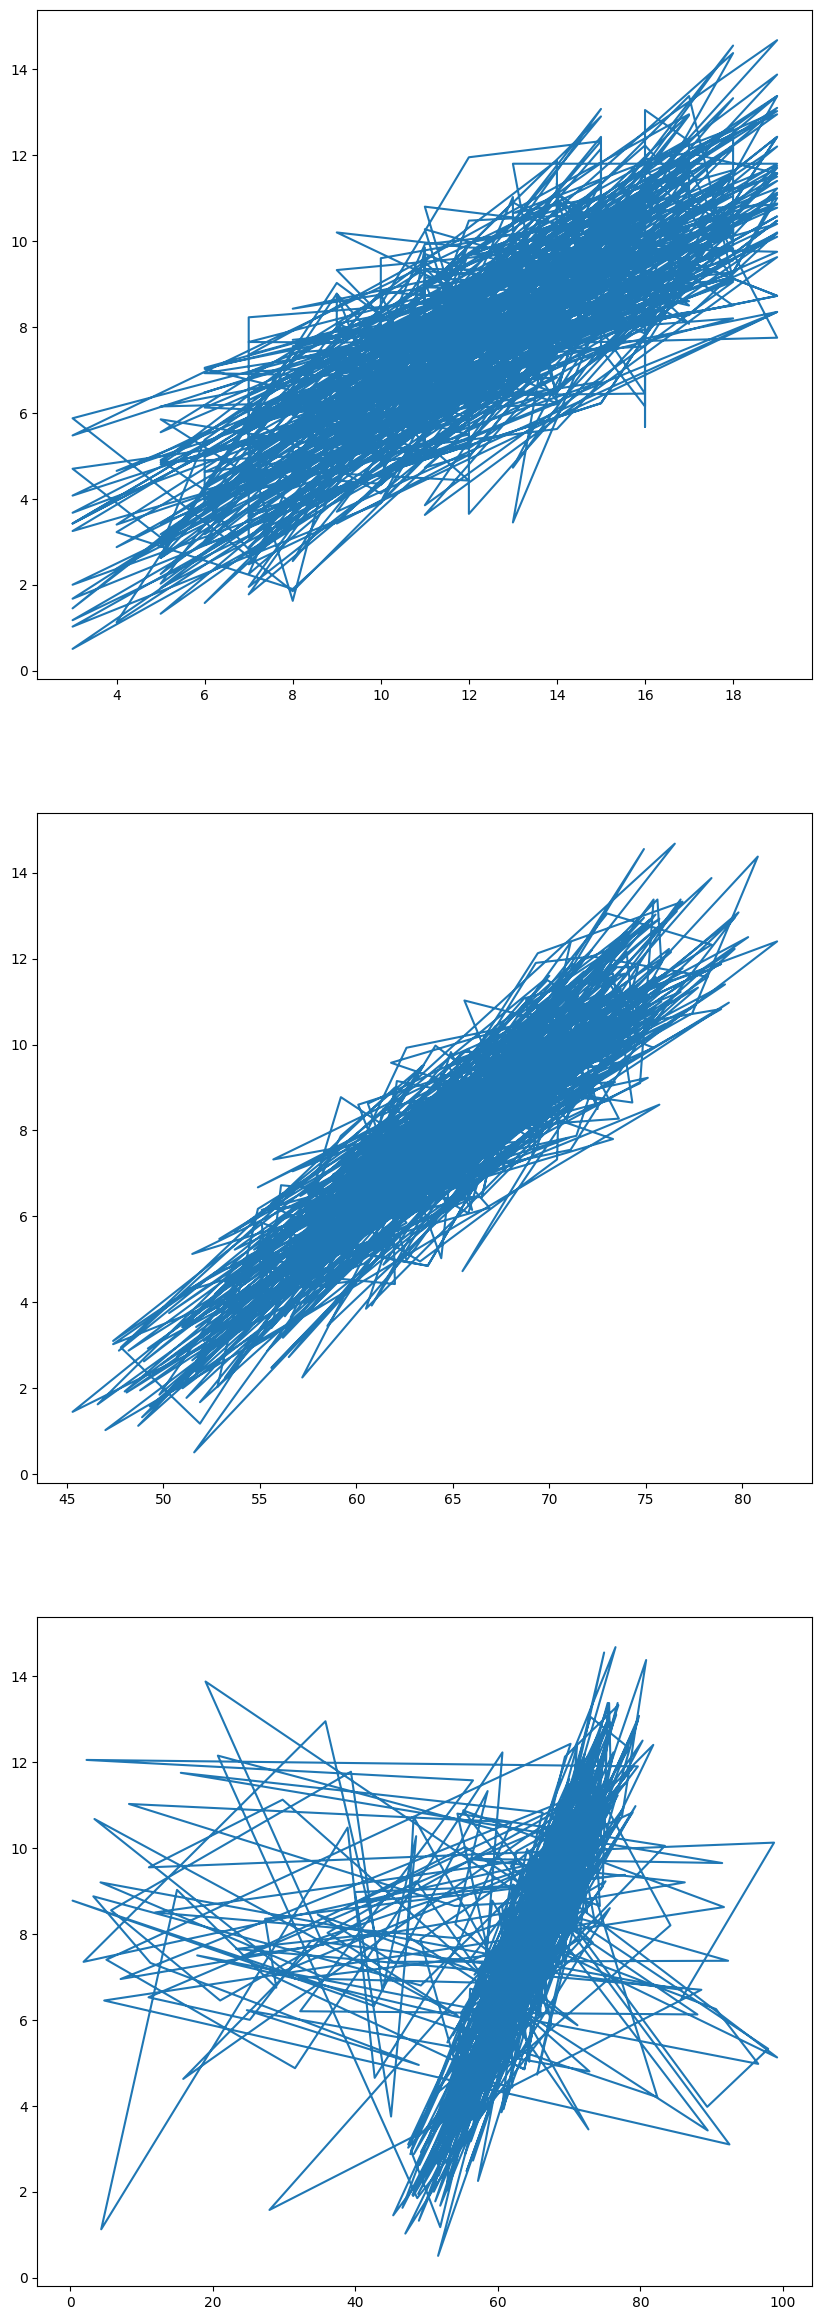

In [85]:
#plotting lung capacity vs other numerical features
plt.figure(figsize = (10,40))
a=1
for xi in ['Age( years)','Height(inches)','Weight (kg)']:
  x = df[xi]
  plt.subplot(4,1,a)
  a+=1;
  plt.plot(x,y)
plt.show()

##feature selection
as the features are pretty low . I have chosen to skip feature selction

##test train split

In [86]:
#test train split
a, b, c, d = train_test_split(X, y, test_size=0.25, random_state=42)
#converting into torch tensors
X_train = torch.from_numpy(a).to(device)
X_test = torch.from_numpy(b).to(device)
y_train = torch.tensor(c).to(device)
y_test = torch.tensor(d).to(device)
X_train.device


device(type='cpu')

##model architecture

## 1. using random forests

a - X_train

b - X_test

c - y_train

d - y_test

In [87]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
regressor.fit(a, c)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [89]:
from sklearn.metrics import mean_absolute_error
predictions = regressor.predict(b)
mse = mean_absolute_error(d,predictions)
print(mse)

0.8954430659943154


In [93]:
for i,j in zip(predictions,d):
  print(str(round(i,2))+"  -  "+str(j))

11.44  -  11.55
7.4  -  7.425
11.97  -  11.325
7.29  -  6.5
7.98  -  9.0
8.12  -  9.575
6.33  -  7.375
2.74  -  1.675
6.89  -  7.35
8.83  -  9.2
9.14  -  8.125
5.19  -  6.1
8.88  -  7.1
12.58  -  13.875
9.52  -  9.4
6.29  -  5.05
4.37  -  3.825
10.36  -  8.8
9.48  -  9.925
4.46  -  2.25
4.08  -  4.25
6.48  -  5.85
6.2  -  4.85
12.31  -  10.825
7.82  -  7.2
10.64  -  10.65
10.56  -  11.125
6.67  -  6.25
7.19  -  7.475
7.65  -  6.475
5.27  -  3.675
9.57  -  8.55
12.48  -  10.725
7.57  -  5.675
11.94  -  11.575
9.72  -  8.625
8.11  -  10.8
8.7  -  8.35
8.29  -  9.475
7.31  -  8.925
9.42  -  7.55
7.06  -  6.05
8.1  -  8.775
8.68  -  8.85
12.95  -  10.925
9.0  -  9.625
3.88  -  5.05
10.23  -  10.4
7.82  -  7.35
2.82  -  1.925
12.16  -  12.15
9.36  -  10.475
4.37  -  3.925
9.58  -  8.325
4.07  -  3.6
8.91  -  8.6
7.9  -  8.45
5.8  -  4.125
9.29  -  12.125
10.46  -  10.7
12.77  -  11.5
9.39  -  11.075
7.6  -  6.225
9.76  -  10.4
9.02  -  8.375
10.25  -  12.325
4.03  -  2.25
11.21  -  11.4
7.8

the mean squared error in the case of random forests is 0.89

##2. using pytorch

In [96]:
#model architecture cell run this cell before loading the model
class Regression(nn.Module):
  def __init__(self,dropout_rate = 0.2):
    super().__init__()
    self.fc1 = nn.Linear(12,16)
    self.bn1 = nn.BatchNorm1d(16)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(dropout_rate)

    self.fc2 = nn.Linear(16,1)
  def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)  # Apply batch normalization
        out = self.relu1(out)
        out = self.dropout1(out)  # Apply dropout

        # out = self.fc2(out)
        # out = self.bn2(out)  # Apply batch normalization
        # out = self.relu2(out)
        # out = self.dropout2(out)  # Apply dropout

        out = self.fc2(out)

        return out
# model instance
model = Regression().to(device)


the cell below needn't be run while testing the model

In [97]:
#lossfn and optimizer
lossfn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
lossfn2 = nn.L1Loss()
epochs = 4000
#trianing loop
for epoch in range(epochs):

  model.train()

  y_pred = model(X_train)

  loss = lossfn2(y_pred,y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()

  if epoch%400 == 9:
    with torch.inference_mode():
      y_pred2 = model(X_test)
      print(lossfn2(y_pred2,y_test))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([538])) that is different to the input size (torch.Size([538, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180])) that is different to the input size (torch.Size([180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(6.7570)
tensor(2.5099)
tensor(2.4726)
tensor(2.3858)
tensor(2.3558)
tensor(2.3624)
tensor(2.3484)
tensor(2.3424)
tensor(2.3447)
tensor(2.3383)


the mean absolute error in the case of my pytorch model is 2.33
my model performed pretty worse compared to random forest algorithm 😅

---



In [98]:
with torch.inference_mode():
  y_pred = model(X_test)
  for i,j in zip(y_pred,y_test):
    print(str(i)+"-"+str(j))

tensor([8.3048])-tensor(11.5500)
tensor([7.8384])-tensor(7.4250)
tensor([7.8299])-tensor(11.3250)
tensor([8.0157])-tensor(6.5000)
tensor([7.9566])-tensor(9.)
tensor([8.0631])-tensor(9.5750)
tensor([8.4448])-tensor(7.3750)
tensor([8.1802])-tensor(1.6750)
tensor([7.5776])-tensor(7.3500)
tensor([7.9157])-tensor(9.2000)
tensor([8.0333])-tensor(8.1250)
tensor([7.6326])-tensor(6.1000)
tensor([8.0213])-tensor(7.1000)
tensor([8.5694])-tensor(13.8750)
tensor([8.0030])-tensor(9.4000)
tensor([7.8998])-tensor(5.0500)
tensor([8.0452])-tensor(3.8250)
tensor([7.8845])-tensor(8.8000)
tensor([7.9378])-tensor(9.9250)
tensor([7.8517])-tensor(2.2500)
tensor([8.0337])-tensor(4.2500)
tensor([7.8080])-tensor(5.8500)
tensor([7.9540])-tensor(4.8500)
tensor([7.8498])-tensor(10.8250)
tensor([7.7123])-tensor(7.2000)
tensor([7.9366])-tensor(10.6500)
tensor([8.3279])-tensor(11.1250)
tensor([8.6260])-tensor(6.2500)
tensor([8.2047])-tensor(7.4750)
tensor([8.0238])-tensor(6.4750)
tensor([7.8072])-tensor(3.6750)
tensor

 saving model and using it from saved state

In [99]:
#saving model
torch.save(model.state_dict(),'/content/modelparams.pt')

upload the file with model parameters and run the below cell and the one where 'regressor class' is defined to acess the model

In [100]:
#loading model from last saved state
new_model  = Regression()
new_model.load_state_dict(torch.load('/content/modelparams.pt'))

<All keys matched successfully>